In [3]:
import json
from collections import defaultdict
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import numpy as np
from sklearn.metrics import mean_absolute_error
from matplotlib.ticker import ScalarFormatter
import statistics as stat

import proxima_analysis as pa

from IPython.core.display import display, HTML
display(HTML('<style>.container { width:100% !important; }</style>'))

BIG    = 22
MEDIUM = 20
FIGWIDTH=12
WIDTH = 0.25  # the width of the bars
NARROW=0.2

XLINE  = 523.21
YLINE  = 0.002

colors = ['#E27100', '#1b85b8', '#559e83', '#b26167']

# Starting to define standardized colors
MAE_COLOR =colors[1]
TIME_COLOR=colors[0]

FIXED_COLOR  = 'tbd'
STATIC_COLOR = 'tbd'
DYNAMIC_COLOR= 'tbd'

FIXED_MARKER='tbd'
STATIC_MARKER='tbd'
DYNAMIC_MARKER='tbd'

In [17]:
experiments = [
    'dynLns_r4',
    'dynLns_r5',
    'dynLns_r6',
    'dynLns_r7',
    'dynLns_r8',
    'dynLns_r9',
    'dynLns_r10',
]

root_path = '/Users/yzamora/Desktop/proxima_analysis/proxima_data'

In [18]:
rog_hf = defaultdict(list)
run_name = 'random-seed_runs/hf_rog'
file = "/".join([root_path, run_name,'result*'])
for f in glob.glob(file):
    control_fn = os.path.basename(f).split('_')
    temp = control_fn[1].split(".json")[0]
    with open(f) as data:
        rog_hf[temp].append(
            json.loads(
                data.read()
            ).get("r_g", None).get("statistic", None)
        )
        
temps = []; rogs_mean = []; rogs_std = []
for k, v in rog_hf.items():
    temps.append(float(k))
    rogs_mean.append(np.mean(v))
    rogs_std.append(np.std(v)/np.sqrt(len(v)-1))

temps, rogs_mean, rogs_std = zip(*sorted(zip(temps, rogs_mean, rogs_std)))

In [19]:
rog_dynLns = defaultdict(list)

#run_name = 'random-seed_runs/dynLns_*'
run_name = 'random-seed_runs/true_runs'
dirs = "/".join([root_path, run_name])

for d in glob.glob(dirs):
    
    subdirs = "/".join([d, "*"])
    for s in glob.glob(subdirs):
    
        control_fn = os.path.basename(s).split('_')
        temp = control_fn[6]
        try:
            with open(s + '/result.json') as data:
                rog_dynLns[temp].append(
                    json.loads(
                        data.read()
                    ).get("r_g", None).get("statistic", None)
                )
        except:
            pass

temps_dynLns = []; rogs_dynLns_mean = []; rogs_dynLns_std = []
for k, v in rog_dynLns.items():
    temps_dynLns.append(float(k))
    rogs_dynLns_mean.append(np.mean(v))
    rogs_dynLns_std.append(np.std(v)/np.sqrt(len(v)))

temps_dynLns, rogs_dynLns_mean, rogs_dynLns_std = zip(
    *sorted(zip(temps_dynLns, rogs_dynLns_mean, rogs_dynLns_std))
)

# Mean ROG vs Temperature

Text(0, 0.5, 'Mean RoG')

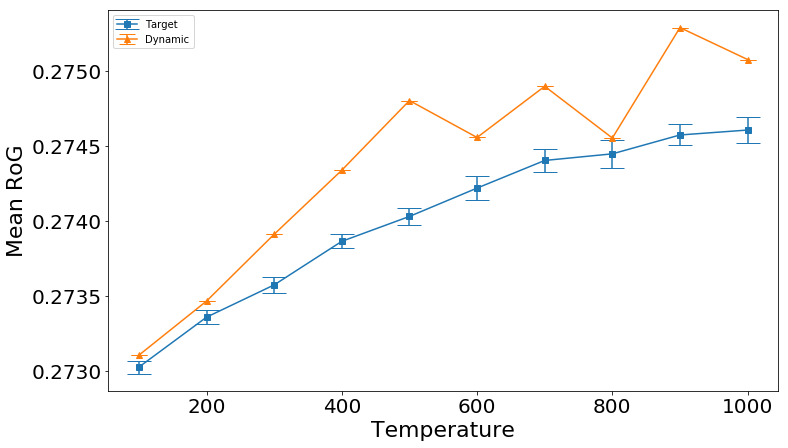

In [20]:
fig, ax = plt.subplots(figsize=(FIGWIDTH,7))

plt.xlabel('Execution time',fontsize=BIG)
plt.ylabel('Mean absolute error', fontsize=BIG)
plt.xticks(fontsize=MEDIUM)
plt.yticks(fontsize=MEDIUM)
ax.yaxis.get_offset_text().set_fontsize(MEDIUM)
ax.errorbar(temps,rogs_mean,yerr=rogs_std,label='Target', capsize=12.0, fmt="s-")
ax.errorbar(temps_dynLns,rogs_dynLns_mean,yerr=rogs_dynLns_std,label='Dynamic', capsize=8.0, fmt="^-")
#ax.errorbar(temps,mean_d,yerr=[d_mins,d_maxes],label='Dynamic', capsize=8.0, fmt="o-")

plt.legend()
plt.xlabel('Temperature')
plt.ylabel('Mean RoG')

## Mean Time vs Temperature

In [21]:
#root_path_hf = '/home/yzamora/proxima/examples/molecule-sampling'
run_name = 'random-seed_runs/runtime_random-seeds/*'
path_str = '/'.join([root_path,run_name])
temp_hf_data =  defaultdict(list)
rs = defaultdict(list)
for d in glob.glob(path_str):
    hf = pd.read_csv(d).set_index("Temp[K]")
    for i in hf.index:
        temp_hf_data[i].append(float(hf.loc[i]))
        

In [22]:
temps_hf = []; runtime_hf_mean = []; runtime_hf_std = []
for i,k in temp_hf_data.items():
    temps_hf.append(float(i))
    runtime_hf_mean.append(np.mean(k))
    runtime_hf_std.append(np.std(k)/np.sqrt(len(k)))
    
temps_hf, runtime_hf_mean, runtime_hf_std = zip(
    *sorted(zip(temps_hf, runtime_hf_mean, runtime_hf_std))
)

In [23]:
hf_times = pd.DataFrame(
    {
        "Temp[K]": np.array(temps_hf, dtype="int"),
        "Runtime[s]": runtime_hf_mean
    }
)


In [59]:
results = {n: None for n in experiments}
for name in results:
    path_str = "/".join([root_path, 'random-seed_runs',name, "*"])
    path = glob.glob(path_str)
    uq_thresholds, int_list, total_time, uq_time, speed_up = pa.process_times(path,hf_times)
    
    time_df = pa.time_to_df(uq_time)
    speedup_df = pa.speedup_to_df(speed_up)
    mae_values = pa.process_mae(path)
    mae_df = pa.mae_to_df(mae_values)
    #results[name] = time_df.merge(mae_df, on=["uq", "interval","temperature"], how="inner")
    time_mae = time_df.merge(mae_df, on=["uq", "interval","temperature"], how="inner")
    results[name]=speedup_df.merge(time_mae, on=["uq", "interval","temperature"], how="inner")

In [60]:
results

{'dynLns_r4':     uq  interval  temperature  speed_up     time       mae
 0  0.5         1          100     5.217  119.568  0.000518
 1  0.5         1         1000     1.363  453.307  0.001654
 2  0.5         1          200     6.004  107.942  0.001078
 3  0.5         1          300     4.125  156.126  0.000834
 4  0.5         1          400     4.186  157.505  0.001104
 5  0.5         1          500     2.022  319.331  0.001232
 6  0.5         1          600     1.958  324.702  0.001708
 7  0.5         1          700     1.137  556.570  0.001101
 8  0.5         1          800     1.477  418.799  0.001495
 9  0.5         1          900     1.129  553.519  0.001378,
 'dynLns_r5':     uq  interval  temperature  speed_up     time       mae
 0  0.5         1          100     8.431   73.993  0.001074
 1  0.5         1         1000     0.997  619.571  0.001169
 2  0.5         1          200     4.652  139.310  0.000577
 3  0.5         1          300     2.535  253.979  0.000750
 4  0.5      

In [75]:
data_temp = {}
cols = ["speed_up", "time", "mae"]

for i,k in results.items():
    data = k.set_index('temperature')
    for t in data.index:
        
        if t not in data_temp:
            data_temp[t] = defaultdict(list)
        
        record = data.loc[t]
        
        for col in cols:
            data_temp[t][col].append(float(record[col]))

In [76]:
summary = defaultdict(list)
for i, k in data_temp.items():
    summary["temps"].append(float(i))
    for col in cols:
        summary[col + "_mean"].append(np.mean(k[col]))
        summary[col + "_std"].append(np.std(k[col])/np.sqrt(len(k[col])))
    
keys = ["temps"] + [k for k in summary.keys() if k != "temps"]
result = list(zip(*sorted(zip(*[summary[k] for k in keys]))))
for i, k in enumerate(keys):
    summary[k] = result[i]
summary

defaultdict(list,
            {'temps': (100.0,
              200.0,
              300.0,
              400.0,
              500.0,
              600.0,
              700.0,
              800.0,
              900.0,
              1000.0),
             'speed_up_mean': (6.0158571428571435,
              5.486428571428571,
              4.037428571428571,
              2.783428571428572,
              2.154714285714286,
              2.0062857142857142,
              1.6362857142857143,
              1.467857142857143,
              1.2002857142857144,
              1.3945714285714286),
             'speed_up_std': (0.6292003810659429,
              0.9259939581312756,
              0.5303916095445125,
              0.3267921299693622,
              0.2771782535780175,
              0.2710279535463059,
              0.16993728906788952,
              0.31228423921828,
              0.09669871456962037,
              0.28243510052015647),
             'time_mean': (113.05814285714287,
   